### Import Function and Libraries

In [2]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from Data_Retrieval import DataRetrieval
from CC_test import CCstudy
import itertools
from pandas_datareader import data as pdr

In [3]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Import TW exchange counters

Our main focus in on Taiwan exchange counters hence we will import taiwan exchange ticker code and retrieve the adjusted closing price from yahoo finance API.

In [7]:
counter_code = pd.read_csv('taiwan_stocks.csv')

In [8]:
tickers = list(counter_code.iloc[:,2].apply(lambda x: str(x)+".tw"))

In [9]:
#tickers = ['2330.tw','TSM']
start_date = "2023-01-01"
end_date = "2024-11-30"

if tickers is not None:
    merged_df = DataRetrieval.retrieve_and_merge_data(tickers, start_date, end_date)
else:
    print("Error: tickers is None")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
merged_df = merged_df.dropna(axis=1, how='any')

### Correlation and Cointegration Study 

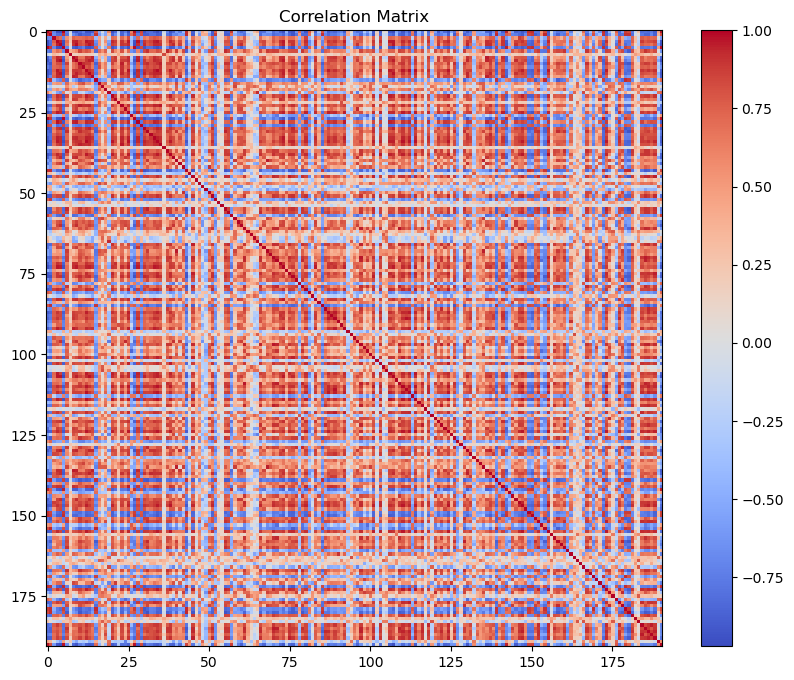


Cointegration Test Results:


In [12]:
cc_study = CCstudy(merged_df)
Correlation, Cointegration = cc_study.main()

In [13]:
Cointegration.sort_values(by='Cointegration result', ascending=True)

,ticker1,ticker2,Cointegration result
2485,1216.tw,3653.tw,0.000002
10057,2332.tw,3380.tw,0.000008
17367,2345.tw,1909.tw,0.000008
6158,2892.tw,5871.tw,0.000017
5781,2884.tw,2393.tw,0.000034
...,...,...,...
983,1301.tw,1718.tw,1.000000
4801,1326.tw,1722.tw,1.000000
14636,3533.tw,8150.tw,1.000000
3709,2603.tw,6285.tw,1.000000


In [14]:
Correlation

,ticker1,ticker2,correlation
